In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Read the data

In [2]:
original_data = pd.read_csv("../day.csv")
original_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
# see information
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


# Data cleaning

In [4]:
# as we don't have any missing values we can directly proceed with original dataset for visualisation
# let's drop instant and dteday column as those do not have any significance
# drop casual and registered columns as well, as those are similar as cnt just represent different categories
data = original_data.drop(["instant", "casual", "registered", "dteday"], axis=1)
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


# Visualise the data

<Figure size 1000x800 with 0 Axes>

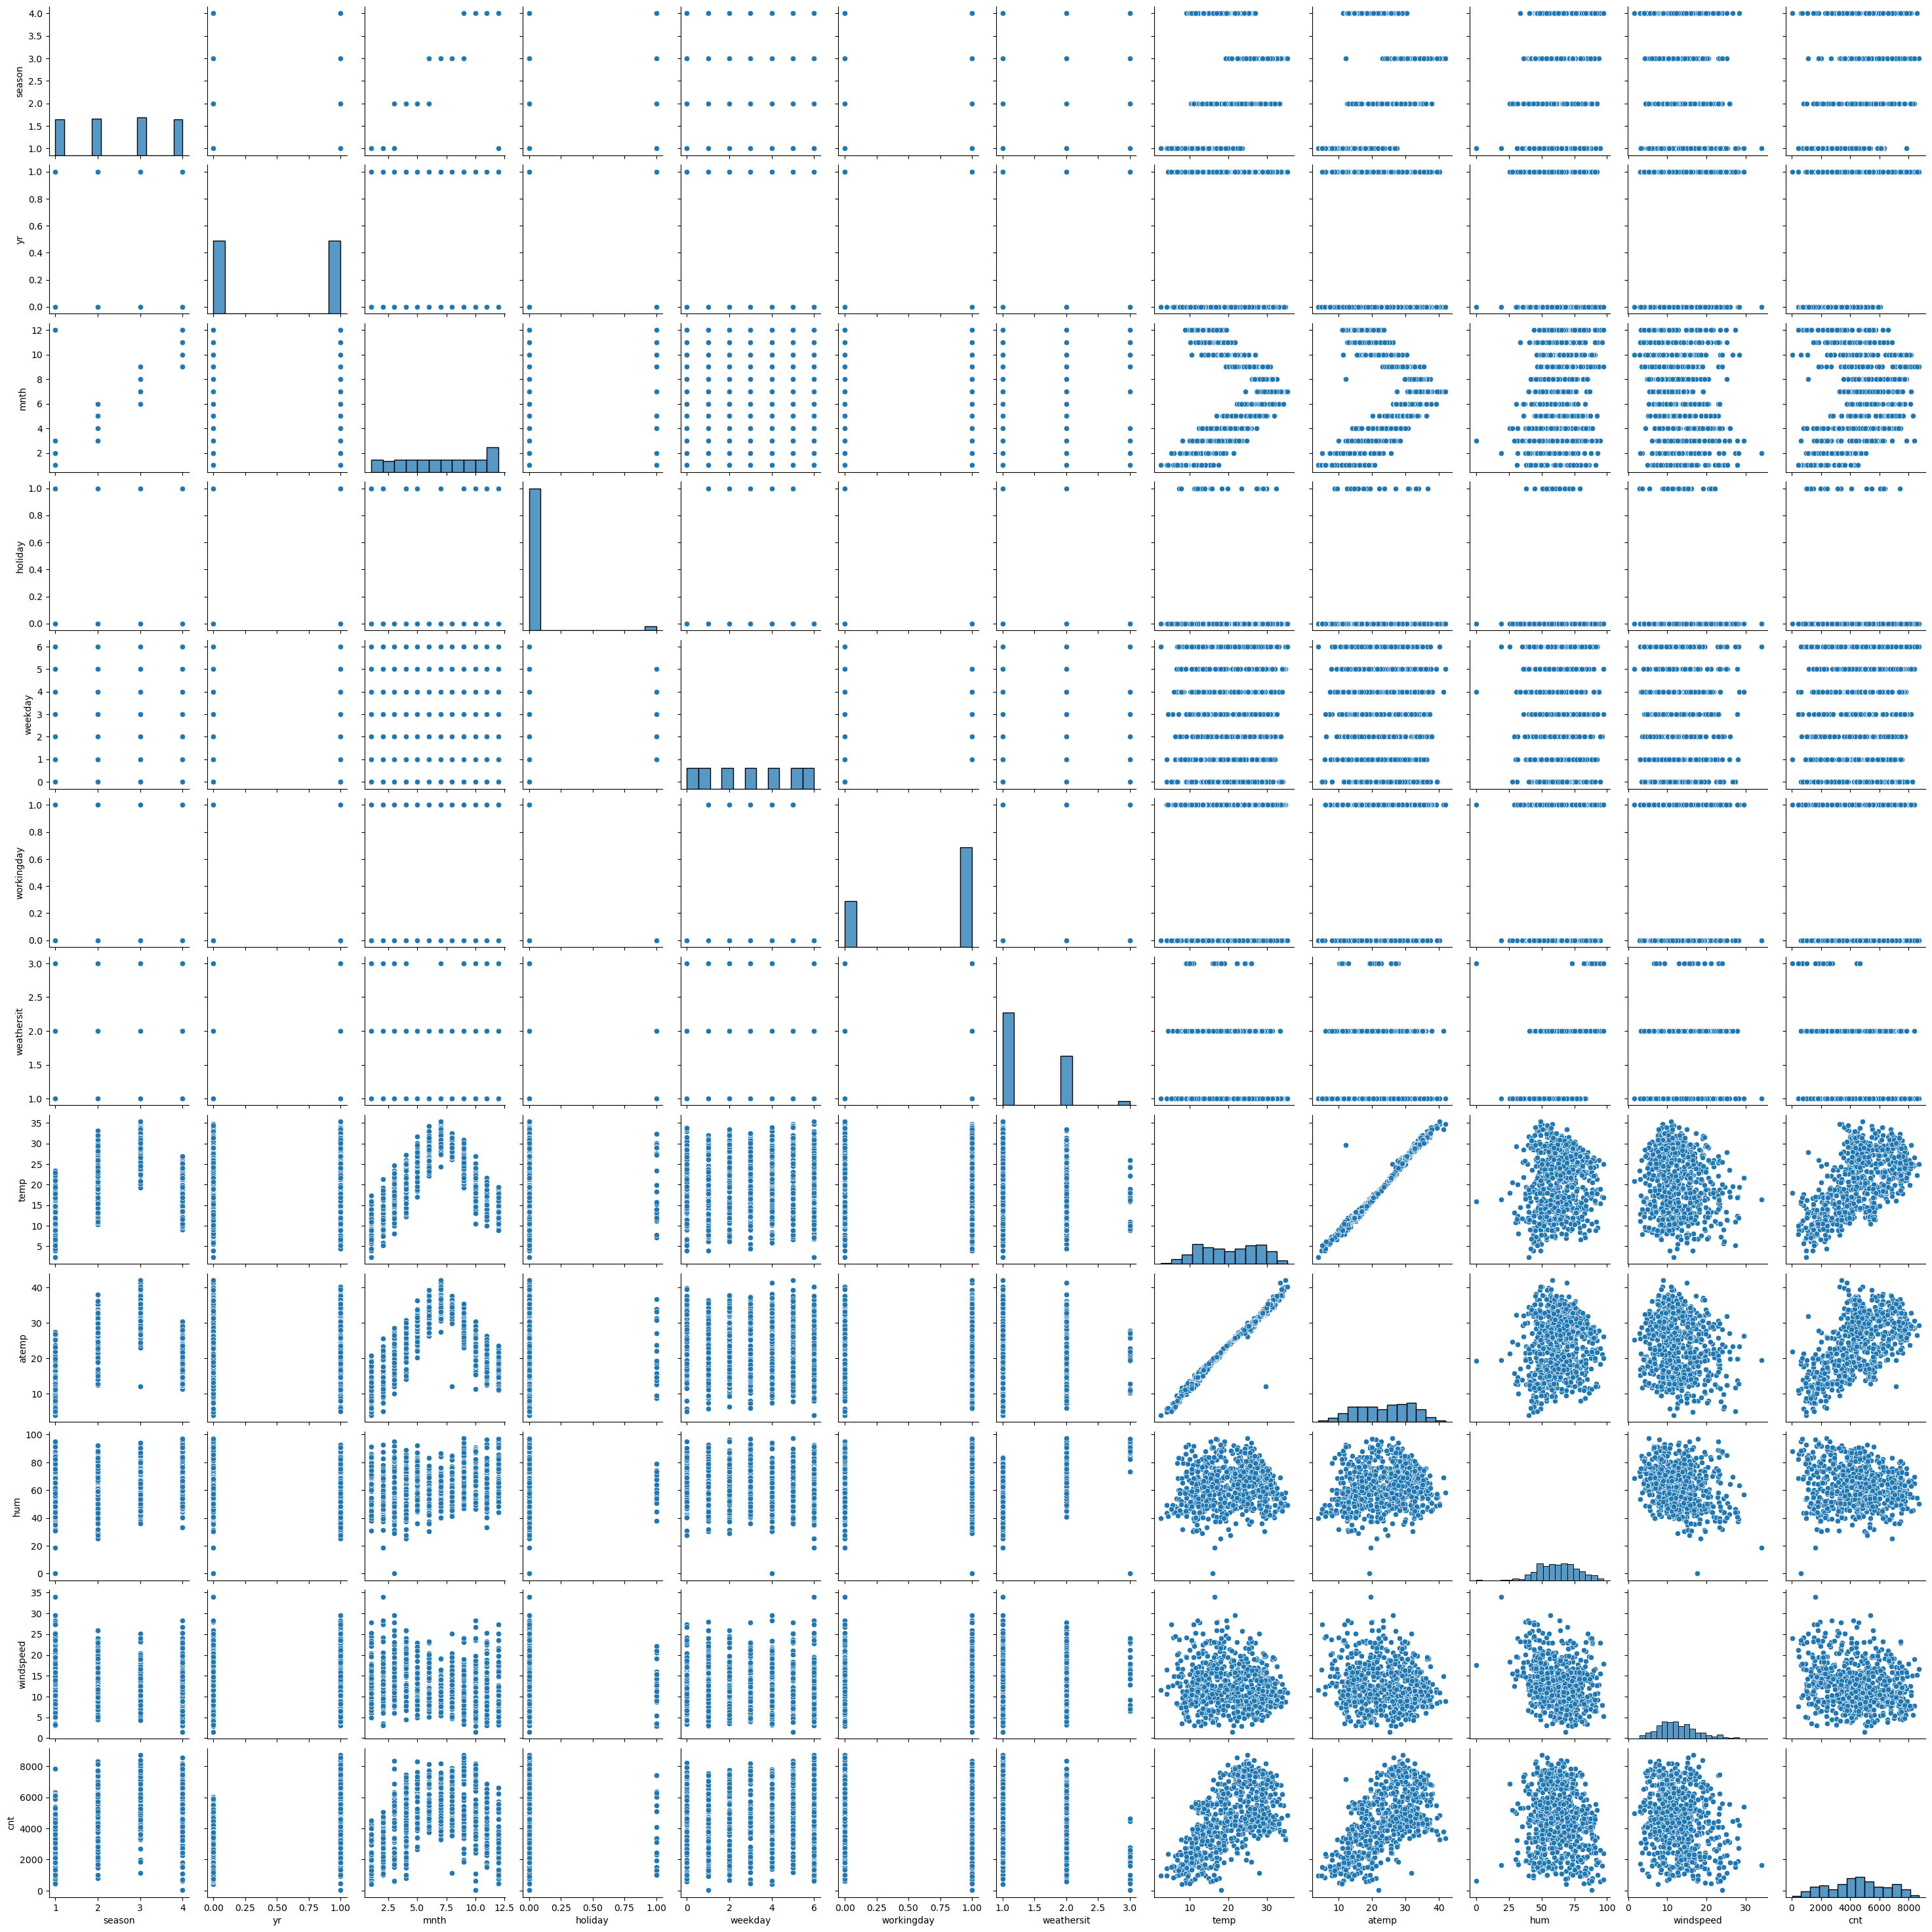

In [5]:
# let's first visualise the numeric variables to see relation of target variable with other variables

fig = plt.figure(figsize=(10,8))
sns.pairplot(data)
plt.show()

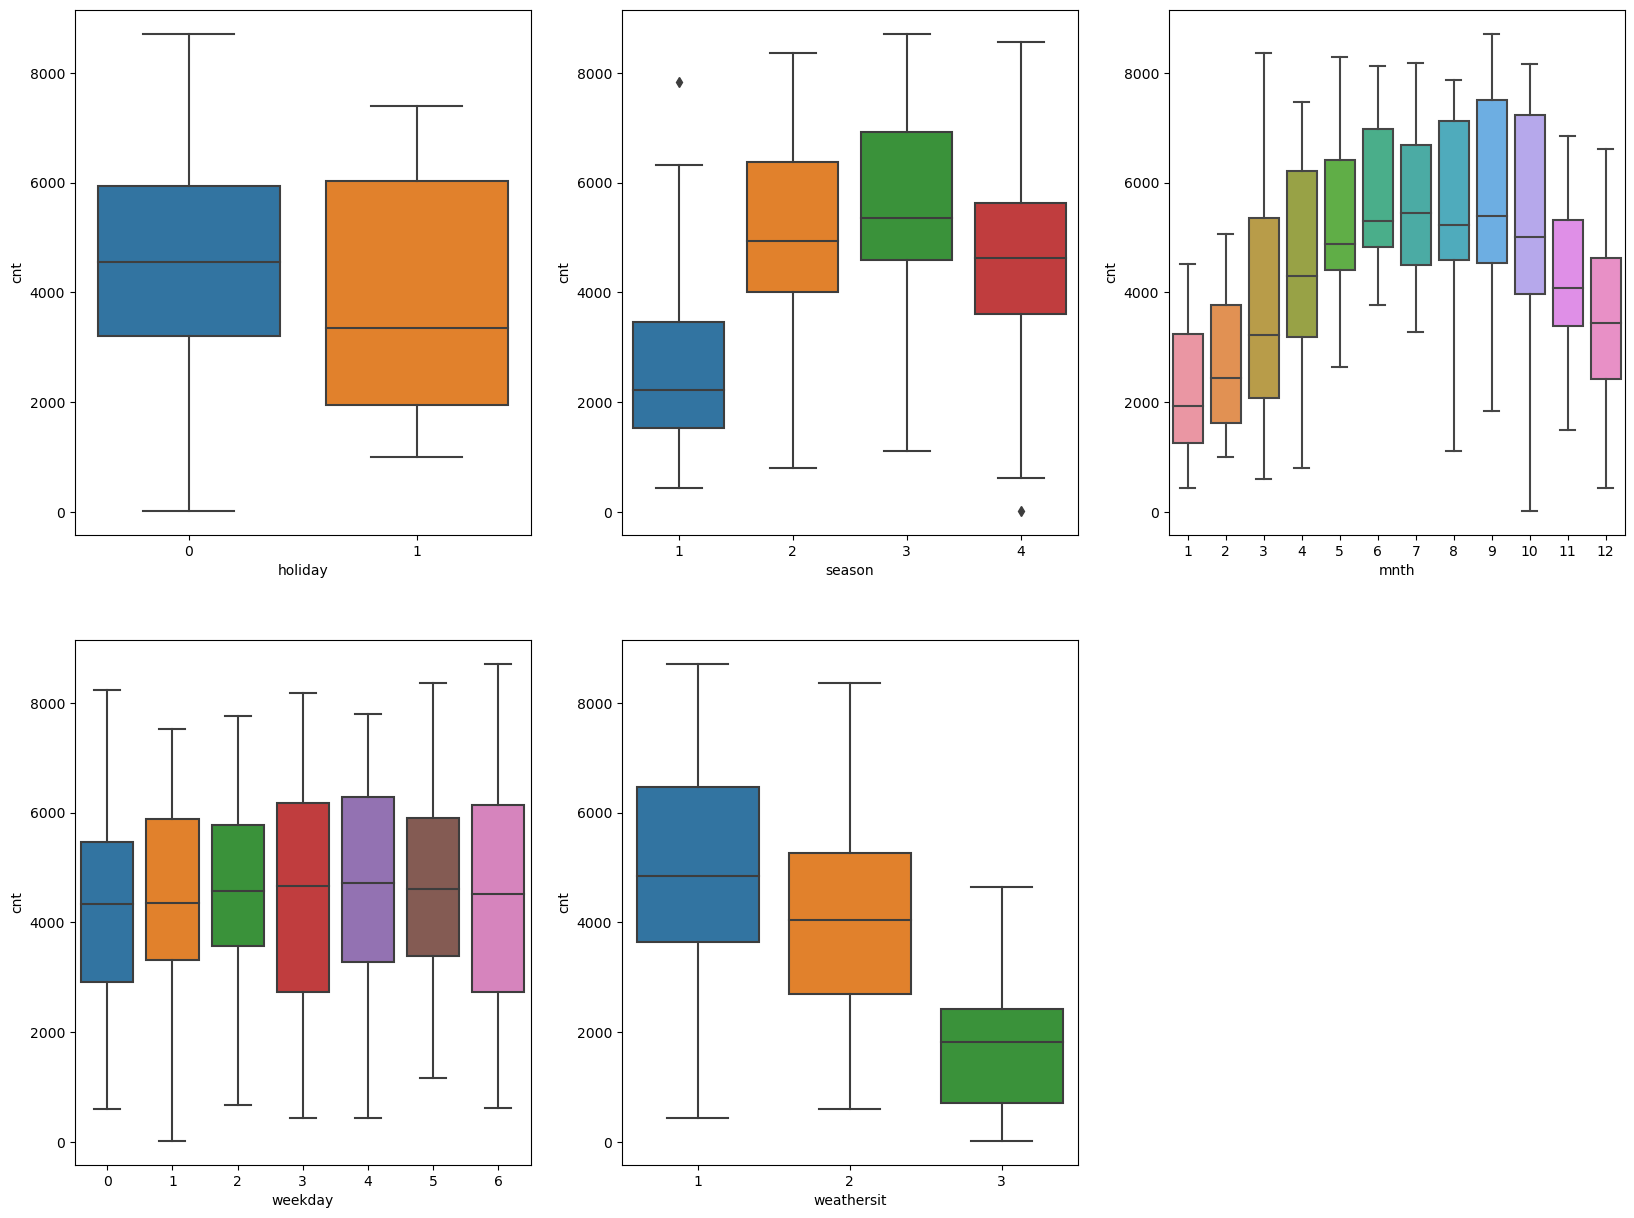

In [6]:
# let's visualise categorical variables

plt.figure(figsize=(20,15))
plt.subplot(2,3,1)
sns.boxplot(data=data, x="holiday", y="cnt")
plt.subplot(2,3,2)
sns.boxplot(data=data, x="season", y="cnt")
plt.subplot(2,3,3)
sns.boxplot(data=data, x="mnth", y="cnt")
plt.subplot(2,3,4)
sns.boxplot(data=data, x="weekday", y="cnt")
plt.subplot(2,3,5)
sns.boxplot(data=data, x="weathersit", y="cnt")
plt.show()

# Dummy variables

In [7]:
# let's map weathersit, season, weekday and mnth to respective names as these values do show any order

data[["weathersit"]] = data[['weathersit']].apply(lambda x: x.map({1:"Clear", 2: "Mist", 3: "Cloudy", 4: "Rainy"}))
data[["season"]] = data[['season']].apply(lambda x: x.map({1:"Spring", 2: "Summer", 3: "Fall", 4: "Winter"}))
data[["weekday"]] = data[['weekday']].apply(lambda x: x.map({0:'Sunday', 1:"Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5:'Friday', 6: 'Saturday'}))
data[['mnth']] = data[['mnth']].apply(lambda x: x.map({1: "Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}))
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,0,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,Spring,0,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,Spring,0,Jan,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,Spring,0,Jan,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,Spring,0,Jan,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


### let's create dummy variables for each

In [8]:
dummy = pd.get_dummies(data['mnth'],drop_first=True)

dummy.head()

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [9]:
weather = pd.get_dummies(data['weathersit'],drop_first=True)

weather.head()

,Cloudy,Mist
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0


In [10]:
season = pd.get_dummies(data['season'],drop_first=True)

season.head()

,Spring,Summer,Winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [11]:
weekday = pd.get_dummies(data['weekday'],drop_first=True)

weekday.head()

,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,1,0,0,0,0
1,0,0,1,0,0,0
2,1,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,0,1


In [12]:
data = pd.concat([data, dummy, weather, season, weekday], axis=1)

In [13]:
data = data.drop(['mnth', 'weathersit', 'season', 'weekday'], axis=1)
data.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Aug,Dec,...,Mist,Spring,Summer,Winter,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,...,1,1,0,0,0,1,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,...,1,1,0,0,0,0,1,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,...,0,1,0,0,1,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,...,0,1,0,0,0,0,0,0,0,1


## Split the data

In [14]:
df_train, df_test = train_test_split(data, train_size=0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 30)
(220, 30)


# Rescale the numeric variables

In [15]:
scaler = MinMaxScaler()

numeric_var = ["temp", "atemp", "hum", "windspeed", "cnt"]

df_train[numeric_var] = scaler.fit_transform(df_train[numeric_var])

df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Aug,Dec,...,Mist,Spring,Summer,Winter,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,0,0,0,0,0,1,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,0,0,...,1,1,0,0,0,1,0,0,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,0,1,...,0,1,0,0,0,0,1,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,0,...,1,0,1,0,0,1,0,0,0,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,0,...,1,0,1,0,0,0,0,0,0,0


In [16]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Aug,Dec,...,Mist,Spring,Summer,Winter,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.096078,0.084314,...,0.345098,0.243137,0.247059,0.247059,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.294988,0.278131,...,0.475867,0.429398,0.431725,0.431725,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Train the model

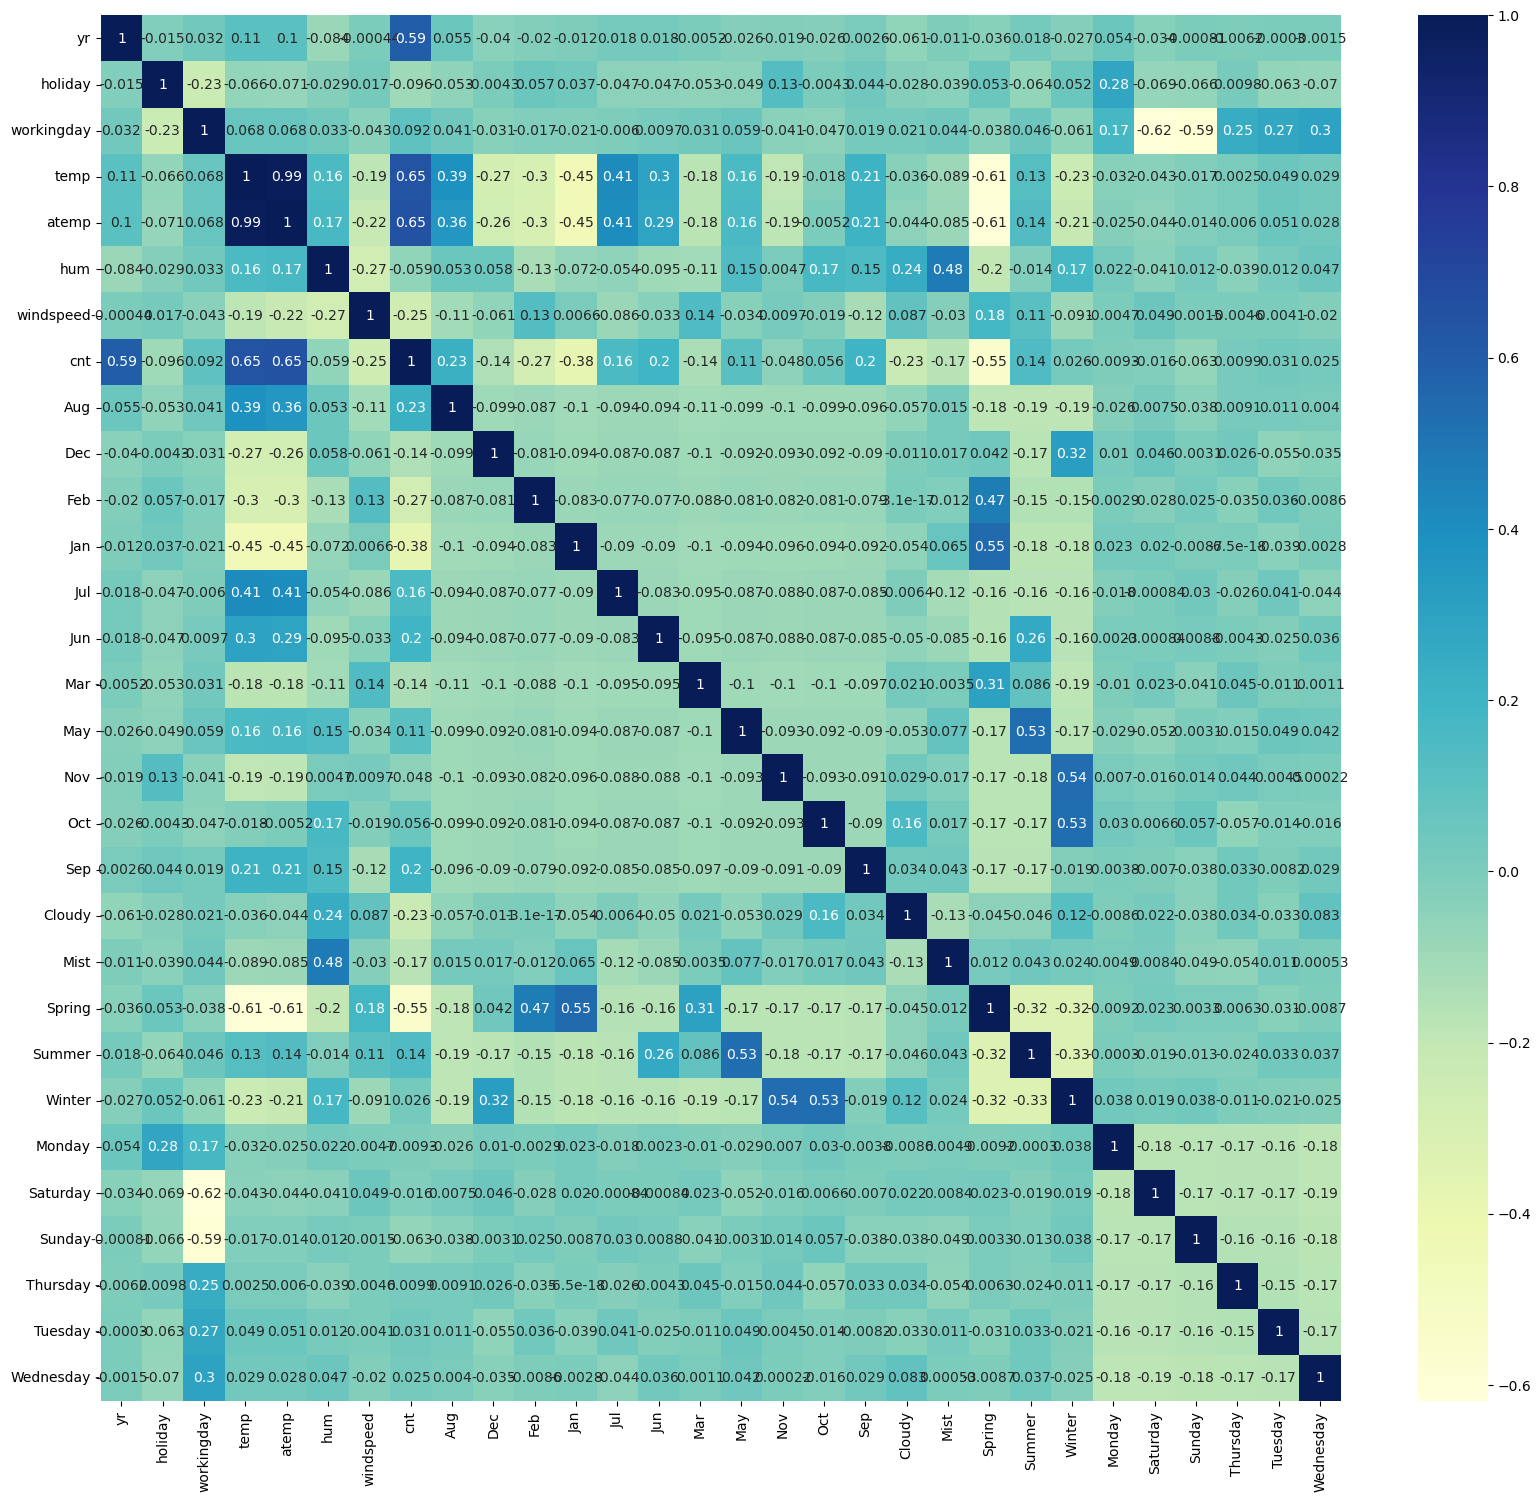

In [17]:
# let's see the correlation of all variables with each other

plt.figure(figsize=(20, 18))
sns.heatmap(df_train.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [18]:
# Now, let's split the train data into X_train and y_train
y_train = df_train.pop("cnt")
X_train = df_train

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 576 to 520
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          510 non-null    int64  
 1   holiday     510 non-null    int64  
 2   workingday  510 non-null    int64  
 3   temp        510 non-null    float64
 4   atemp       510 non-null    float64
 5   hum         510 non-null    float64
 6   windspeed   510 non-null    float64
 7   Aug         510 non-null    uint8  
 8   Dec         510 non-null    uint8  
 9   Feb         510 non-null    uint8  
 10  Jan         510 non-null    uint8  
 11  Jul         510 non-null    uint8  
 12  Jun         510 non-null    uint8  
 13  Mar         510 non-null    uint8  
 14  May         510 non-null    uint8  
 15  Nov         510 non-null    uint8  
 16  Oct         510 non-null    uint8  
 17  Sep         510 non-null    uint8  
 18  Cloudy      510 non-null    uint8  
 19  Mist        510 non-null   

In [20]:
# let's see which variable do not have significance using RFE method

lr = LinearRegression()
lr.fit(X_train, y_train)
rfe = RFE(estimator=lr, n_features_to_select=len(X_train))
rfe = rfe.fit(X_train, y_train)

In [21]:
list(zip(X_train.columns, rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Aug', True, 1),
 ('Dec', True, 1),
 ('Feb', True, 1),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', True, 1),
 ('Mar', True, 1),
 ('May', True, 1),
 ('Nov', True, 1),
 ('Oct', True, 1),
 ('Sep', True, 1),
 ('Cloudy', True, 1),
 ('Mist', True, 1),
 ('Spring', True, 1),
 ('Summer', True, 1),
 ('Winter', True, 1),
 ('Monday', True, 1),
 ('Saturday', True, 1),
 ('Sunday', True, 1),
 ('Thursday', True, 1),
 ('Tuesday', True, 1),
 ('Wednesday', True, 1)]

#### all variables have significance with target variable
let's proceed with the manual method

In [22]:
# add a constant
X_train_sm = sm.add_constant(X_train)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     99.37
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          2.81e-180
Time:                        12:44:43   Log-Likelihood:                 527.12
No. Observations:                 510   AIC:                            -996.2
Df Residuals:                     481   BIC:                            -873.4
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2433      0.035      6.887      0.000       0.174       0.313
yr             0.2325      0.008     28.794      0.000       0.217       0.248
holiday        0.0109      0.024      0.451      0.652      -0.037       0.058
workingday     0.0963      0.012      7.835      0.000       0.072       0.120
temp           0.3880      0.142      2.727      0.007       0.108       0.668
atemp          0.0590      0.138      0.426      0.670      -0.213       0.331
hum           -0.1520      0.039     -3.938      0.000      -0.228      -0.076
windspeed     -0.1836      0.026     -6.962      0.000      -0.235      -0.132
Aug            0.0223      0.034      0.657      0.511      -0.044       0.089
Dec           -0.0443      0.034     -1.316      0.189      -0.110       0.022
Feb           -0.0323      0.033     -0.980      0.327      -0.097       0.032
Jan           -0.0631      0.034     -1.876      0.061      -0.129       0.003
Jul           -0.0327      0.035     -0.931      0.352      -0.102       0.036
Jun            0.0060      0.025      0.241      0.810      -0.043       0.055
Mar            0.0016      0.025      0.063      0.950      -0.047       0.050
May            0.0255      0.021      1.208      0.228      -0.016       0.067
Nov           -0.0398      0.036     -1.093      0.275      -0.111       0.032
Oct            0.0077      0.036      0.215      0.830      -0.063       0.078
Sep            0.0868      0.032      2.711      0.007       0.024       0.150
Cloudy        -0.2550      0.026     -9.631      0.000      -0.307      -0.203
Mist          -0.0595      0.010     -5.701      0.000      -0.080      -0.039
Spring        -0.0454      0.030     -1.511      0.131      -0.104       0.014
Summer         0.0424      0.026      1.617      0.107      -0.009       0.094
Winter         0.1071      0.028      3.826      0.000       0.052       0.162
Monday        -0.0216      0.015     -1.401      0.162      -0.052       0.009
Saturday       0.0952      0.014      6.910      0.000       0.068       0.122
Sunday         0.0410      0.014      2.929      0.004       0.013       0.068
Thursday      -0.0097      0.016     -0.623      0.534      -0.040       0.021
Tuesday       -0.0184      0.016     -1.184      0.237      -0.049       0.012
Wednesday     -0.0059      0.015     -0.394      0.694      -0.035       0.023
==============================================================================
Omnibus:                       84.490   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.656
Skew:                          -0.805   Prob(JB):                     1.11e-51
Kurtosis:                       5.907   Cond. No.                     7.51e+15
==============================================================================

N

In [23]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,workingday,85.557802
3,temp,66.896825
4,atemp,56.027582
24,Saturday,19.708035
25,Sunday,18.342515
20,Spring,10.765395
22,Winter,9.461499
21,Summer,8.291722
15,Nov,6.788200
7,Aug,6.469361


In [24]:
# let's remove variables with higher p-value and analyse the r2_score

X = X_train.drop(['Mar'], axis=1)

In [25]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     103.3
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          2.75e-181
Time:                        12:44:44   Log-Likelihood:                 527.12
No. Observations:                 510   AIC:                            -998.2
Df Residuals:                     482   BIC:                            -879.7
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2441      0.033      7.380      0.000       0.179       0.309
yr             0.2325      0.008     28.824      0.000       0.217       0.248
holiday        0.0111      0.024      0.462      0.645      -0.036       0.058
workingday     0.0965      0.012      8.151      0.000       0.073       0.120
temp           0.3877      0.142      2.729      0.007       0.109       0.667
atemp          0.0588      0.138      0.425      0.671      -0.213       0.330
hum           -0.1518      0.038     -3.950      0.000      -0.227      -0.076
windspeed     -0.1837      0.026     -6.983      0.000      -0.235      -0.132
Aug            0.0216      0.032      0.676      0.499      -0.041       0.084
Dec           -0.0456      0.026     -1.755      0.080      -0.097       0.005
Feb           -0.0338      0.022     -1.517      0.130      -0.078       0.010
Jan           -0.0646      0.022     -2.892      0.004      -0.109      -0.021
Jul           -0.0333      0.033     -0.999      0.318      -0.099       0.032
Jun            0.0055      0.024      0.233      0.816      -0.041       0.052
May            0.0251      0.020      1.268      0.205      -0.014       0.064
Nov           -0.0410      0.031     -1.333      0.183      -0.102       0.019
Oct            0.0065      0.031      0.213      0.831      -0.054       0.067
Sep            0.0859      0.029      2.961      0.003       0.029       0.143
Cloudy        -0.2550      0.026     -9.641      0.000      -0.307      -0.203
Mist          -0.0595      0.010     -5.708      0.000      -0.080      -0.039
Spring        -0.0447      0.028     -1.575      0.116      -0.101       0.011
Summer         0.0421      0.026      1.637      0.102      -0.008       0.093
Winter         0.1074      0.027      3.910      0.000       0.053       0.161
Monday        -0.0216      0.015     -1.402      0.162      -0.052       0.009
Saturday       0.0954      0.013      7.159      0.000       0.069       0.122
Sunday         0.0411      0.014      3.011      0.003       0.014       0.068
Thursday      -0.0097      0.016     -0.622      0.535      -0.040       0.021
Tuesday       -0.0184      0.016     -1.185      0.237      -0.049       0.012
Wednesday     -0.0059      0.015     -0.394      0.694      -0.035       0.023
==============================================================================
Omnibus:                       84.449   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.878
Skew:                          -0.804   Prob(JB):                     9.93e-52
Kurtosis:                       5.910   Cond. No.                     7.47e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

In [26]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,workingday,74.904332
3,temp,66.843235
4,atemp,55.987578
23,Saturday,17.213292
24,Sunday,16.188171
19,Spring,9.657341
21,Winter,9.133219
20,Summer,7.985587
7,Aug,5.740607
11,Jul,5.110969


In [27]:
# let's drop a temp as well. However, temp and atemp are highly correlated

X = X.drop(['Oct'], axis=1)

In [28]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     107.4
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          2.68e-182
Time:                        12:44:45   Log-Likelihood:                 527.10
No. Observations:                 510   AIC:                            -1000.
Df Residuals:                     483   BIC:                            -885.9
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2455      0.032      7.586      0.000       0.182       0.309
yr             0.2325      0.008     28.873      0.000       0.217       0.248
holiday        0.0117      0.024      0.494      0.622      -0.035       0.058
workingday     0.0967      0.012      8.209      0.000       0.074       0.120
temp           0.3882      0.142      2.736      0.006       0.109       0.667
atemp          0.0589      0.138      0.427      0.670      -0.212       0.330
hum           -0.1511      0.038     -3.951      0.000      -0.226      -0.076
windspeed     -0.1835      0.026     -6.986      0.000      -0.235      -0.132
Aug            0.0190      0.029      0.644      0.520      -0.039       0.077
Dec           -0.0495      0.018     -2.687      0.007      -0.086      -0.013
Feb           -0.0349      0.022     -1.608      0.108      -0.078       0.008
Jan           -0.0657      0.022     -3.010      0.003      -0.109      -0.023
Jul           -0.0360      0.031     -1.161      0.246      -0.097       0.025
Jun            0.0043      0.023      0.187      0.852      -0.041       0.049
May            0.0246      0.020      1.253      0.211      -0.014       0.063
Nov           -0.0462      0.019     -2.426      0.016      -0.084      -0.009
Sep            0.0827      0.025      3.336      0.001       0.034       0.131
Cloudy        -0.2548      0.026     -9.648      0.000      -0.307      -0.203
Mist          -0.0596      0.010     -5.721      0.000      -0.080      -0.039
Spring        -0.0460      0.028     -1.655      0.099      -0.101       0.009
Summer         0.0400      0.024      1.684      0.093      -0.007       0.087
Winter         0.1101      0.024      4.539      0.000       0.062       0.158
Monday        -0.0217      0.015     -1.408      0.160      -0.052       0.009
Saturday       0.0956      0.013      7.210      0.000       0.070       0.122
Sunday         0.0414      0.014      3.051      0.002       0.015       0.068
Thursday      -0.0097      0.016     -0.625      0.532      -0.040       0.021
Tuesday       -0.0185      0.016     -1.190      0.235      -0.049       0.012
Wednesday     -0.0059      0.015     -0.396      0.693      -0.035       0.023
==============================================================================
Omnibus:                       83.679   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.048
Skew:                          -0.799   Prob(JB):                     6.74e-51
Kurtosis:                       5.884   Cond. No.                     7.47e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.08e-29. This might indicate

In [29]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,workingday,72.289095
3,temp,66.826369
4,atemp,55.986922
22,Saturday,16.599144
23,Sunday,15.582263
18,Spring,9.257290
20,Winter,7.141270
19,Summer,6.836308
7,Aug,4.901148
11,Jul,4.416548


In [30]:
X = X.drop(['Jun'], axis=1)

In [31]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     112.0
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          2.55e-183
Time:                        12:44:46   Log-Likelihood:                 527.08
No. Observations:                 510   AIC:                            -1002.
Df Residuals:                     484   BIC:                            -892.1
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2457      0.032      7.604      0.000       0.182       0.309
yr             0.2323      0.008     29.009      0.000       0.217       0.248
holiday        0.0114      0.024      0.483      0.630      -0.035       0.058
workingday     0.0968      0.012      8.231      0.000       0.074       0.120
temp           0.3961      0.135      2.926      0.004       0.130       0.662
atemp          0.0554      0.137      0.405      0.685      -0.213       0.324
hum           -0.1520      0.038     -4.015      0.000      -0.226      -0.078
windspeed     -0.1841      0.026     -7.081      0.000      -0.235      -0.133
Aug            0.0157      0.024      0.662      0.508      -0.031       0.062
Dec           -0.0490      0.018     -2.690      0.007      -0.085      -0.013
Feb           -0.0343      0.021     -1.599      0.110      -0.077       0.008
Jan           -0.0648      0.021     -3.045      0.002      -0.107      -0.023
Jul           -0.0394      0.025     -1.598      0.111      -0.088       0.009
May            0.0229      0.017      1.319      0.188      -0.011       0.057
Nov           -0.0459      0.019     -2.421      0.016      -0.083      -0.009
Sep            0.0804      0.021      3.744      0.000       0.038       0.123
Cloudy        -0.2548      0.026     -9.657      0.000      -0.307      -0.203
Mist          -0.0595      0.010     -5.725      0.000      -0.080      -0.039
Spring        -0.0474      0.027     -1.771      0.077      -0.100       0.005
Summer         0.0393      0.023      1.677      0.094      -0.007       0.085
Winter         0.1086      0.023      4.756      0.000       0.064       0.153
Monday        -0.0216      0.015     -1.403      0.161      -0.052       0.009
Saturday       0.0959      0.013      7.264      0.000       0.070       0.122
Sunday         0.0416      0.014      3.079      0.002       0.015       0.068
Thursday      -0.0097      0.016     -0.624      0.533      -0.040       0.021
Tuesday       -0.0185      0.016     -1.190      0.235      -0.049       0.012
Wednesday     -0.0058      0.015     -0.390      0.697      -0.035       0.023
==============================================================================
Omnibus:                       83.300   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.416
Skew:                          -0.798   Prob(JB):                     2.51e-50
Kurtosis:                       5.864   Cond. No.                     6.92e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.58e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is 

In [32]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,workingday,72.179554
3,temp,60.918977
4,atemp,54.958368
21,Saturday,16.545868
22,Sunday,15.537789
17,Spring,8.598760
18,Summer,6.658680
19,Winter,6.336754
1,holiday,3.975253
7,Aug,3.192387


In [33]:
X = X.drop(['Wednesday'], axis=1)

In [34]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     116.8
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          2.52e-184
Time:                        12:44:47   Log-Likelihood:                 527.00
No. Observations:                 510   AIC:                            -1004.
Df Residuals:                     485   BIC:                            -898.1
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2450      0.032      7.601      0.000       0.182       0.308
yr             0.2323      0.008     29.032      0.000       0.217       0.248
holiday        0.0099      0.023      0.423      0.672      -0.036       0.056
workingday     0.0949      0.011      8.853      0.000       0.074       0.116
temp           0.3987      0.135      2.952      0.003       0.133       0.664
atemp          0.0523      0.136      0.383      0.702      -0.216       0.320
hum           -0.1526      0.038     -4.036      0.000      -0.227      -0.078
windspeed     -0.1842      0.026     -7.091      0.000      -0.235      -0.133
Aug            0.0158      0.024      0.665      0.506      -0.031       0.062
Dec           -0.0490      0.018     -2.690      0.007      -0.085      -0.013
Feb           -0.0343      0.021     -1.600      0.110      -0.076       0.008
Jan           -0.0649      0.021     -3.053      0.002      -0.107      -0.023
Jul           -0.0392      0.025     -1.589      0.113      -0.088       0.009
May            0.0229      0.017      1.322      0.187      -0.011       0.057
Nov           -0.0462      0.019     -2.444      0.015      -0.083      -0.009
Sep            0.0803      0.021      3.742      0.000       0.038       0.122
Cloudy        -0.2556      0.026     -9.719      0.000      -0.307      -0.204
Mist          -0.0592      0.010     -5.717      0.000      -0.080      -0.039
Spring        -0.0475      0.027     -1.777      0.076      -0.100       0.005
Summer         0.0391      0.023      1.672      0.095      -0.007       0.085
Winter         0.1087      0.023      4.762      0.000       0.064       0.153
Monday        -0.0183      0.013     -1.415      0.158      -0.044       0.007
Saturday       0.0972      0.013      7.639      0.000       0.072       0.122
Sunday         0.0430      0.013      3.295      0.001       0.017       0.069
Thursday      -0.0064      0.013     -0.492      0.623      -0.032       0.019
Tuesday       -0.0152      0.013     -1.162      0.246      -0.041       0.011
==============================================================================
Omnibus:                       82.771   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.939
Skew:                          -0.793   Prob(JB):                     5.26e-50
Kurtosis:                       5.857   Cond. No.                     6.89e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.58e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [35]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,workingday,70.216891
3,temp,60.771725
4,atemp,54.767119
21,Saturday,16.519893
22,Sunday,15.512548
17,Spring,8.597361
18,Summer,6.656645
19,Winter,6.336662
1,holiday,3.918141
7,Aug,3.192251


In [36]:
X = X.drop(['atemp'], axis=1)

In [37]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     122.1
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          2.42e-185
Time:                        12:44:48   Log-Likelihood:                 526.92
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     486   BIC:                            -904.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2447      0.032      7.601      0.000       0.181       0.308
yr             0.2322      0.008     29.055      0.000       0.217       0.248
holiday        0.0092      0.023      0.398      0.691      -0.036       0.055
workingday     0.0949      0.011      8.858      0.000       0.074       0.116
temp           0.4483      0.038     11.674      0.000       0.373       0.524
hum           -0.1518      0.038     -4.025      0.000      -0.226      -0.078
windspeed     -0.1862      0.025     -7.319      0.000      -0.236      -0.136
Aug            0.0151      0.024      0.638      0.524      -0.031       0.061
Dec           -0.0489      0.018     -2.689      0.007      -0.085      -0.013
Feb           -0.0344      0.021     -1.603      0.110      -0.076       0.008
Jan           -0.0651      0.021     -3.067      0.002      -0.107      -0.023
Jul           -0.0392      0.025     -1.591      0.112      -0.088       0.009
May            0.0227      0.017      1.311      0.191      -0.011       0.057
Nov           -0.0462      0.019     -2.443      0.015      -0.083      -0.009
Sep            0.0803      0.021      3.746      0.000       0.038       0.122
Cloudy        -0.2563      0.026     -9.782      0.000      -0.308      -0.205
Mist          -0.0593      0.010     -5.730      0.000      -0.080      -0.039
Spring        -0.0467      0.027     -1.755      0.080      -0.099       0.006
Summer         0.0399      0.023      1.716      0.087      -0.006       0.086
Winter         0.1095      0.023      4.830      0.000       0.065       0.154
Monday        -0.0179      0.013     -1.389      0.165      -0.043       0.007
Saturday       0.0974      0.013      7.663      0.000       0.072       0.122
Sunday         0.0432      0.013      3.313      0.001       0.018       0.069
Thursday      -0.0061      0.013     -0.467      0.640      -0.032       0.020
Tuesday       -0.0150      0.013     -1.145      0.253      -0.041       0.011
==============================================================================
Omnibus:                       82.216   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.232
Skew:                          -0.788   Prob(JB):                     1.23e-49
Kurtosis:                       5.849   Cond. No.                     6.68e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.51e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [38]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,workingday,70.181519
20,Saturday,16.518526
21,Sunday,15.511450
16,Spring,8.549952
17,Summer,6.600716
18,Winter,6.271460
3,temp,4.921471
1,holiday,3.908454
6,Aug,3.172966
10,Jul,2.807348


In [39]:
X = X.drop(['holiday'], axis=1)

In [40]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     122.1
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          2.42e-185
Time:                        12:44:49   Log-Likelihood:                 526.92
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     486   BIC:                            -904.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2539      0.048      5.250      0.000       0.159       0.349
yr             0.2322      0.008     29.055      0.000       0.217       0.248
workingday     0.0856      0.026      3.248      0.001       0.034       0.137
temp           0.4483      0.038     11.674      0.000       0.373       0.524
hum           -0.1518      0.038     -4.025      0.000      -0.226      -0.078
windspeed     -0.1862      0.025     -7.319      0.000      -0.236      -0.136
Aug            0.0151      0.024      0.638      0.524      -0.031       0.061
Dec           -0.0489      0.018     -2.689      0.007      -0.085      -0.013
Feb           -0.0344      0.021     -1.603      0.110      -0.076       0.008
Jan           -0.0651      0.021     -3.067      0.002      -0.107      -0.023
Jul           -0.0392      0.025     -1.591      0.112      -0.088       0.009
May            0.0227      0.017      1.311      0.191      -0.011       0.057
Nov           -0.0462      0.019     -2.443      0.015      -0.083      -0.009
Sep            0.0803      0.021      3.746      0.000       0.038       0.122
Cloudy        -0.2563      0.026     -9.782      0.000      -0.308      -0.205
Mist          -0.0593      0.010     -5.730      0.000      -0.080      -0.039
Spring        -0.0467      0.027     -1.755      0.080      -0.099       0.006
Summer         0.0399      0.023      1.716      0.087      -0.006       0.086
Winter         0.1095      0.023      4.830      0.000       0.065       0.154
Monday        -0.0179      0.013     -1.389      0.165      -0.043       0.007
Saturday       0.0881      0.029      3.043      0.002       0.031       0.145
Sunday         0.0339      0.029      1.168      0.244      -0.023       0.091
Thursday      -0.0061      0.013     -0.467      0.640      -0.032       0.020
Tuesday       -0.0150      0.013     -1.145      0.253      -0.041       0.011
==============================================================================
Omnibus:                       82.216   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.232
Skew:                          -0.788   Prob(JB):                     1.23e-49
Kurtosis:                       5.849   Cond. No.                         30.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,hum,36.382009
2,temp,24.249001
1,workingday,20.832215
15,Spring,8.391016
16,Summer,6.698399
17,Winter,6.688460
19,Saturday,5.905404
20,Sunday,5.577303
4,windspeed,5.129351
5,Aug,3.263809


In [42]:
X = X.drop(['Thursday'], axis=1)

In [43]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     127.9
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          2.36e-186
Time:                        12:44:50   Log-Likelihood:                 526.81
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     487   BIC:                            -910.2
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2512      0.048      5.235      0.000       0.157       0.345
yr             0.2322      0.008     29.077      0.000       0.217       0.248
workingday     0.0861      0.026      3.269      0.001       0.034       0.138
temp           0.4484      0.038     11.686      0.000       0.373       0.524
hum           -0.1516      0.038     -4.024      0.000      -0.226      -0.078
windspeed     -0.1863      0.025     -7.327      0.000      -0.236      -0.136
Aug            0.0152      0.024      0.645      0.520      -0.031       0.062
Dec           -0.0492      0.018     -2.709      0.007      -0.085      -0.014
Feb           -0.0340      0.021     -1.590      0.112      -0.076       0.008
Jan           -0.0650      0.021     -3.066      0.002      -0.107      -0.023
Jul           -0.0389      0.025     -1.583      0.114      -0.087       0.009
May            0.0228      0.017      1.317      0.188      -0.011       0.057
Nov           -0.0466      0.019     -2.472      0.014      -0.084      -0.010
Sep            0.0803      0.021      3.747      0.000       0.038       0.122
Cloudy        -0.2565      0.026     -9.797      0.000      -0.308      -0.205
Mist          -0.0591      0.010     -5.719      0.000      -0.079      -0.039
Spring        -0.0466      0.027     -1.753      0.080      -0.099       0.006
Summer         0.0401      0.023      1.726      0.085      -0.006       0.086
Winter         0.1099      0.023      4.851      0.000       0.065       0.154
Monday        -0.0160      0.012     -1.310      0.191      -0.040       0.008
Saturday       0.0905      0.028      3.175      0.002       0.034       0.146
Sunday         0.0363      0.029      1.268      0.205      -0.020       0.092
Tuesday       -0.0131      0.012     -1.052      0.293      -0.037       0.011
==============================================================================
Omnibus:                       82.702   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.333
Skew:                          -0.792   Prob(JB):                     4.32e-50
Kurtosis:                       5.862   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,hum,36.339046
2,temp,24.141413
1,workingday,20.796075
15,Spring,8.358942
17,Winter,6.684734
16,Summer,6.684089
19,Saturday,5.805439
20,Sunday,5.485110
4,windspeed,5.120766
5,Aug,3.262605


In [45]:
X = X.drop(['Aug'], axis=1)

In [46]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     134.1
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          2.47e-187
Time:                        12:44:51   Log-Likelihood:                 526.59
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     488   BIC:                            -916.0
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2594      0.046      5.611      0.000       0.169       0.350
yr             0.2324      0.008     29.128      0.000       0.217       0.248
workingday     0.0863      0.026      3.282      0.001       0.035       0.138
temp           0.4502      0.038     11.769      0.000       0.375       0.525
hum           -0.1505      0.038     -4.001      0.000      -0.224      -0.077
windspeed     -0.1864      0.025     -7.338      0.000      -0.236      -0.137
Dec           -0.0500      0.018     -2.758      0.006      -0.086      -0.014
Feb           -0.0340      0.021     -1.591      0.112      -0.076       0.008
Jan           -0.0650      0.021     -3.067      0.002      -0.107      -0.023
Jul           -0.0498      0.018     -2.770      0.006      -0.085      -0.014
May            0.0224      0.017      1.299      0.195      -0.012       0.056
Nov           -0.0476      0.019     -2.534      0.012      -0.085      -0.011
Sep            0.0716      0.017      4.303      0.000       0.039       0.104
Cloudy        -0.2573      0.026     -9.847      0.000      -0.309      -0.206
Mist          -0.0588      0.010     -5.703      0.000      -0.079      -0.039
Spring        -0.0564      0.022     -2.576      0.010      -0.099      -0.013
Summer         0.0298      0.017      1.766      0.078      -0.003       0.063
Winter         0.1009      0.018      5.663      0.000       0.066       0.136
Monday        -0.0160      0.012     -1.317      0.188      -0.040       0.008
Saturday       0.0911      0.028      3.201      0.001       0.035       0.147
Sunday         0.0364      0.029      1.275      0.203      -0.020       0.093
Tuesday       -0.0129      0.012     -1.040      0.299      -0.037       0.011
==============================================================================
Omnibus:                       83.893   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.497
Skew:                          -0.803   Prob(JB):                     8.87e-51
Kurtosis:                       5.875   Cond. No.                         28.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
X = X.drop(["Tuesday"], axis=1)

In [48]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     140.7
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          3.51e-188
Time:                        12:44:51   Log-Likelihood:                 526.03
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     489   BIC:                            -921.1
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2580      0.046      5.582      0.000       0.167       0.349
yr             0.2323      0.008     29.122      0.000       0.217       0.248
workingday     0.0856      0.026      3.254      0.001       0.034       0.137
temp           0.4505      0.038     11.777      0.000       0.375       0.526
hum           -0.1518      0.038     -4.038      0.000      -0.226      -0.078
windspeed     -0.1869      0.025     -7.358      0.000      -0.237      -0.137
Dec           -0.0492      0.018     -2.718      0.007      -0.085      -0.014
Feb           -0.0350      0.021     -1.636      0.102      -0.077       0.007
Jan           -0.0649      0.021     -3.062      0.002      -0.107      -0.023
Jul           -0.0507      0.018     -2.825      0.005      -0.086      -0.015
May            0.0222      0.017      1.285      0.199      -0.012       0.056
Nov           -0.0475      0.019     -2.525      0.012      -0.084      -0.011
Sep            0.0718      0.017      4.314      0.000       0.039       0.104
Cloudy        -0.2557      0.026     -9.802      0.000      -0.307      -0.204
Mist          -0.0586      0.010     -5.683      0.000      -0.079      -0.038
Spring        -0.0562      0.022     -2.566      0.011      -0.099      -0.013
Summer         0.0296      0.017      1.751      0.081      -0.004       0.063
Winter         0.1004      0.018      5.639      0.000       0.065       0.135
Monday        -0.0130      0.012     -1.102      0.271      -0.036       0.010
Saturday       0.0934      0.028      3.289      0.001       0.038       0.149
Sunday         0.0389      0.029      1.364      0.173      -0.017       0.095
==============================================================================
Omnibus:                       84.077   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.009
Skew:                          -0.797   Prob(JB):                     5.64e-52
Kurtosis:                       5.926   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
X = X.drop(['Monday'], axis=1)

In [50]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     148.0
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          5.20e-189
Time:                        12:44:51   Log-Likelihood:                 525.39
No. Observations:                 510   AIC:                            -1011.
Df Residuals:                     490   BIC:                            -926.1
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2478      0.045      5.472      0.000       0.159       0.337
yr             0.2318      0.008     29.103      0.000       0.216       0.247
workingday     0.0933      0.025      3.679      0.000       0.043       0.143
temp           0.4527      0.038     11.846      0.000       0.378       0.528
hum           -0.1538      0.038     -4.094      0.000      -0.228      -0.080
windspeed     -0.1873      0.025     -7.371      0.000      -0.237      -0.137
Dec           -0.0488      0.018     -2.692      0.007      -0.084      -0.013
Feb           -0.0348      0.021     -1.626      0.105      -0.077       0.007
Jan           -0.0650      0.021     -3.067      0.002      -0.107      -0.023
Jul           -0.0510      0.018     -2.844      0.005      -0.086      -0.016
May            0.0229      0.017      1.325      0.186      -0.011       0.057
Nov           -0.0461      0.019     -2.456      0.014      -0.083      -0.009
Sep            0.0723      0.017      4.349      0.000       0.040       0.105
Cloudy        -0.2549      0.026     -9.773      0.000      -0.306      -0.204
Mist          -0.0583      0.010     -5.655      0.000      -0.079      -0.038
Spring        -0.0553      0.022     -2.528      0.012      -0.098      -0.012
Summer         0.0295      0.017      1.747      0.081      -0.004       0.063
Winter         0.1001      0.018      5.618      0.000       0.065       0.135
Saturday       0.1036      0.027      3.864      0.000       0.051       0.156
Sunday         0.0492      0.027      1.827      0.068      -0.004       0.102
==============================================================================
Omnibus:                       82.971   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.033
Skew:                          -0.787   Prob(JB):                     2.50e-51
Kurtosis:                       5.914   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,hum,34.746977
2,temp,22.480697
1,workingday,19.105614
14,Spring,6.063144
17,Saturday,5.104775
4,windspeed,5.059688
18,Sunday,4.888020
16,Winter,4.400588
15,Summer,3.712515
7,Jan,2.418229


In [52]:
X = X.drop(['May'], axis=1)

In [53]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     155.9
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          9.80e-190
Time:                        12:44:52   Log-Likelihood:                 524.48
No. Observations:                 510   AIC:                            -1011.
Df Residuals:                     491   BIC:                            -930.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2368      0.045      5.315      0.000       0.149       0.324
yr             0.2312      0.008     29.052      0.000       0.216       0.247
workingday     0.0942      0.025      3.713      0.000       0.044       0.144
temp           0.4616      0.038     12.262      0.000       0.388       0.536
hum           -0.1477      0.037     -3.958      0.000      -0.221      -0.074
windspeed     -0.1889      0.025     -7.441      0.000      -0.239      -0.139
Dec           -0.0474      0.018     -2.619      0.009      -0.083      -0.012
Feb           -0.0334      0.021     -1.562      0.119      -0.075       0.009
Jan           -0.0634      0.021     -2.991      0.003      -0.105      -0.022
Jul           -0.0515      0.018     -2.868      0.004      -0.087      -0.016
Nov           -0.0444      0.019     -2.371      0.018      -0.081      -0.008
Sep            0.0723      0.017      4.346      0.000       0.040       0.105
Cloudy        -0.2567      0.026     -9.849      0.000      -0.308      -0.206
Mist          -0.0585      0.010     -5.668      0.000      -0.079      -0.038
Spring        -0.0515      0.022     -2.373      0.018      -0.094      -0.009
Summer         0.0393      0.015      2.586      0.010       0.009       0.069
Winter         0.1021      0.018      5.752      0.000       0.067       0.137
Saturday       0.1040      0.027      3.875      0.000       0.051       0.157
Sunday         0.0500      0.027      1.855      0.064      -0.003       0.103
==============================================================================
Omnibus:                       80.597   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.714
Skew:                          -0.784   Prob(JB):                     3.91e-47
Kurtosis:                       5.757   Cond. No.                         27.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,hum,34.636691
2,temp,22.296855
1,workingday,18.923591
13,Spring,6.045074
16,Saturday,5.042688
4,windspeed,4.994035
17,Sunday,4.847705
15,Winter,4.398925
14,Summer,3.105085
7,Jan,2.417960


In [55]:
X = X.drop(['Feb'], axis=1)

In [56]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     164.4
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          2.52e-190
Time:                        12:44:53   Log-Likelihood:                 523.22
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     492   BIC:                            -934.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2235      0.044      5.103      0.000       0.137       0.310
yr             0.2309      0.008     28.978      0.000       0.215       0.247
workingday     0.0964      0.025      3.801      0.000       0.047       0.146
temp           0.4764      0.036     13.064      0.000       0.405       0.548
hum           -0.1494      0.037     -4.001      0.000      -0.223      -0.076
windspeed     -0.1879      0.025     -7.390      0.000      -0.238      -0.138
Dec           -0.0388      0.017     -2.248      0.025      -0.073      -0.005
Jan           -0.0455      0.018     -2.548      0.011      -0.081      -0.010
Jul           -0.0524      0.018     -2.916      0.004      -0.088      -0.017
Nov           -0.0399      0.019     -2.152      0.032      -0.076      -0.003
Sep            0.0737      0.017      4.430      0.000       0.041       0.106
Cloudy        -0.2555      0.026     -9.791      0.000      -0.307      -0.204
Mist          -0.0583      0.010     -5.637      0.000      -0.079      -0.038
Spring        -0.0607      0.021     -2.899      0.004      -0.102      -0.020
Summer         0.0424      0.015      2.809      0.005       0.013       0.072
Winter         0.1038      0.018      5.845      0.000       0.069       0.139
Saturday       0.1068      0.027      3.984      0.000       0.054       0.160
Sunday         0.0520      0.027      1.931      0.054      -0.001       0.105
==============================================================================
Omnibus:                       76.194   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.529
Skew:                          -0.745   Prob(JB):                     2.85e-44
Kurtosis:                       5.687   Cond. No.                         26.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,hum,34.186734
2,temp,21.562378
1,workingday,18.835254
12,Spring,5.063925
15,Saturday,5.031347
4,windspeed,4.987353
16,Sunday,4.827320
14,Winter,4.398063
13,Summer,3.094762
11,Mist,2.345153


In [58]:
X = X.drop(['hum'], axis=1)

In [59]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     168.6
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          4.83e-188
Time:                        12:44:53   Log-Likelihood:                 515.05
No. Observations:                 510   AIC:                            -996.1
Df Residuals:                     493   BIC:                            -924.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1542      0.041      3.776      0.000       0.074       0.234
yr             0.2346      0.008     29.217      0.000       0.219       0.250
workingday     0.0972      0.026      3.776      0.000       0.047       0.148
temp           0.4370      0.036     12.260      0.000       0.367       0.507
windspeed     -0.1602      0.025     -6.452      0.000      -0.209      -0.111
Dec           -0.0458      0.017     -2.627      0.009      -0.080      -0.012
Jan           -0.0517      0.018     -2.864      0.004      -0.087      -0.016
Jul           -0.0475      0.018     -2.609      0.009      -0.083      -0.012
Nov           -0.0407      0.019     -2.162      0.031      -0.078      -0.004
Sep            0.0674      0.017      4.009      0.000       0.034       0.100
Cloudy        -0.2976      0.024    -12.277      0.000      -0.345      -0.250
Mist          -0.0821      0.009     -9.590      0.000      -0.099      -0.065
Spring        -0.0698      0.021     -3.304      0.001      -0.111      -0.028
Summer         0.0356      0.015      2.339      0.020       0.006       0.066
Winter         0.0901      0.018      5.095      0.000       0.055       0.125
Saturday       0.1094      0.027      4.022      0.000       0.056       0.163
Sunday         0.0498      0.027      1.822      0.069      -0.004       0.104
==============================================================================
Omnibus:                       79.557   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.036
Skew:                          -0.766   Prob(JB):                     1.23e-47
Kurtosis:                       5.796   Cond. No.                         24.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
1,workingday,17.173083
2,temp,13.619250
3,windspeed,4.850501
14,Saturday,4.701066
15,Sunday,4.389166
11,Spring,4.242780
13,Winter,3.707490
12,Summer,2.775787
0,yr,2.077804
7,Nov,1.795725


In [61]:
X = X.drop(['Sunday'], axis=1)

In [62]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     178.7
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          1.84e-188
Time:                        12:44:54   Log-Likelihood:                 513.34
No. Observations:                 510   AIC:                            -994.7
Df Residuals:                     494   BIC:                            -926.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1985      0.033      6.031      0.000       0.134       0.263
yr             0.2348      0.008     29.173      0.000       0.219       0.251
workingday     0.0547      0.011      5.009      0.000       0.033       0.076
temp           0.4354      0.036     12.191      0.000       0.365       0.506
windspeed     -0.1609      0.025     -6.464      0.000      -0.210      -0.112
Dec           -0.0467      0.017     -2.675      0.008      -0.081      -0.012
Jan           -0.0526      0.018     -2.905      0.004      -0.088      -0.017
Jul           -0.0466      0.018     -2.554      0.011      -0.082      -0.011
Nov           -0.0447      0.019     -2.389      0.017      -0.081      -0.008
Sep            0.0652      0.017      3.880      0.000       0.032       0.098
Cloudy        -0.2969      0.024    -12.222      0.000      -0.345      -0.249
Mist          -0.0818      0.009     -9.526      0.000      -0.099      -0.065
Spring        -0.0713      0.021     -3.371      0.001      -0.113      -0.030
Summer         0.0354      0.015      2.320      0.021       0.005       0.065
Winter         0.0903      0.018      5.093      0.000       0.055       0.125
Saturday       0.0670      0.014      4.758      0.000       0.039       0.095
==============================================================================
Omnibus:                       85.035   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.570
Skew:                          -0.805   Prob(JB):                     9.50e-53
Kurtosis:                       5.946   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,temp,6.918120
1,workingday,4.737921
3,windspeed,4.714885
11,Spring,3.092115
13,Winter,3.027175
12,Summer,2.330125
0,yr,2.075939
14,Saturday,1.856182
7,Nov,1.790326
5,Jan,1.671644


In [64]:
# let's remove workingday instead of temp as temp has highest correlation with the target variable

X = X.drop(['workingday'], axis=1)

In [65]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     180.9
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          2.61e-184
Time:                        12:44:55   Log-Likelihood:                 500.71
No. Observations:                 510   AIC:                            -971.4
Df Residuals:                     495   BIC:                            -907.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2424      0.032      7.465      0.000       0.179       0.306
yr             0.2353      0.008     28.553      0.000       0.219       0.252
temp           0.4374      0.037     11.960      0.000       0.366       0.509
windspeed     -0.1624      0.025     -6.370      0.000      -0.212      -0.112
Dec           -0.0450      0.018     -2.514      0.012      -0.080      -0.010
Jan           -0.0519      0.019     -2.799      0.005      -0.088      -0.015
Jul           -0.0496      0.019     -2.657      0.008      -0.086      -0.013
Nov           -0.0467      0.019     -2.434      0.015      -0.084      -0.009
Sep            0.0644      0.017      3.743      0.000       0.031       0.098
Cloudy        -0.2893      0.025    -11.651      0.000      -0.338      -0.240
Mist          -0.0788      0.009     -8.987      0.000      -0.096      -0.062
Spring        -0.0745      0.022     -3.440      0.001      -0.117      -0.032
Summer         0.0346      0.016      2.213      0.027       0.004       0.065
Winter         0.0859      0.018      4.741      0.000       0.050       0.122
Saturday       0.0232      0.011      2.055      0.040       0.001       0.045
==============================================================================
Omnibus:                       85.992   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.684
Skew:                          -0.854   Prob(JB):                     1.46e-47
Kurtosis:                       5.690   Cond. No.                         19.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
1,temp,5.194488
2,windspeed,4.690559
12,Winter,2.955868
10,Spring,2.883338
11,Summer,2.243046
0,yr,2.074870
6,Nov,1.785962
4,Jan,1.657247
5,Jul,1.593804
9,Mist,1.562323


In [67]:
X = X.drop(['windspeed'], axis=1)

In [68]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     177.5
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          5.13e-177
Time:                        12:44:55   Log-Likelihood:                 480.62
No. Observations:                 510   AIC:                            -933.2
Df Residuals:                     496   BIC:                            -873.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1804      0.032      5.603      0.000       0.117       0.244
yr             0.2340      0.009     27.328      0.000       0.217       0.251
temp           0.4613      0.038     12.204      0.000       0.387       0.536
Dec           -0.0350      0.019     -1.891      0.059      -0.071       0.001
Jan           -0.0348      0.019     -1.825      0.069      -0.072       0.003
Jul           -0.0506      0.019     -2.610      0.009      -0.089      -0.013
Nov           -0.0491      0.020     -2.465      0.014      -0.088      -0.010
Sep            0.0697      0.018      3.899      0.000       0.035       0.105
Cloudy        -0.3036      0.026    -11.817      0.000      -0.354      -0.253
Mist          -0.0773      0.009     -8.486      0.000      -0.095      -0.059
Spring        -0.0866      0.022     -3.866      0.000      -0.131      -0.043
Summer         0.0261      0.016      1.612      0.108      -0.006       0.058
Winter         0.0893      0.019      4.745      0.000       0.052       0.126
Saturday       0.0196      0.012      1.674      0.095      -0.003       0.043
==============================================================================
Omnibus:                       87.559   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              229.737
Skew:                          -0.853   Prob(JB):                     1.30e-50
Kurtosis:                       5.811   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
1,temp,4.352255
11,Winter,2.819499
9,Spring,2.126439
0,yr,2.071643
10,Summer,1.949630
5,Nov,1.766601
3,Jan,1.651515
4,Jul,1.591859
8,Mist,1.561779
2,Dec,1.468784


In [70]:
X = X.drop(['Summer'], axis=1)

In [71]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     191.5
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          1.32e-177
Time:                        12:44:56   Log-Likelihood:                 479.28
No. Observations:                 510   AIC:                            -932.6
Df Residuals:                     497   BIC:                            -877.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2155      0.024      9.092      0.000       0.169       0.262
yr             0.2344      0.009     27.353      0.000       0.218       0.251
temp           0.4331      0.034     12.913      0.000       0.367       0.499
Dec           -0.0404      0.018     -2.212      0.027      -0.076      -0.005
Jan           -0.0394      0.019     -2.088      0.037      -0.076      -0.002
Jul           -0.0616      0.018     -3.391      0.001      -0.097      -0.026
Nov           -0.0545      0.020     -2.775      0.006      -0.093      -0.016
Sep            0.0580      0.016      3.544      0.000       0.026       0.090
Cloudy        -0.3049      0.026    -11.853      0.000      -0.355      -0.254
Mist          -0.0771      0.009     -8.452      0.000      -0.095      -0.059
Spring        -0.1114      0.016     -6.831      0.000      -0.144      -0.079
Winter         0.0706      0.015      4.761      0.000       0.041       0.100
Saturday       0.0195      0.012      1.662      0.097      -0.004       0.043
==============================================================================
Omnibus:                       89.153   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.587
Skew:                          -0.854   Prob(JB):                     1.28e-53
Kurtosis:                       5.923   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
X = X.drop(['Saturday'], axis=1)

In [73]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     207.9
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          3.52e-178
Time:                        12:44:56   Log-Likelihood:                 477.87
No. Observations:                 510   AIC:                            -931.7
Df Residuals:                     498   BIC:                            -880.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2192      0.024      9.272      0.000       0.173       0.266
yr             0.2340      0.009     27.270      0.000       0.217       0.251
temp           0.4319      0.034     12.858      0.000       0.366       0.498
Dec           -0.0396      0.018     -2.167      0.031      -0.076      -0.004
Jan           -0.0392      0.019     -2.072      0.039      -0.076      -0.002
Jul           -0.0611      0.018     -3.357      0.001      -0.097      -0.025
Nov           -0.0552      0.020     -2.807      0.005      -0.094      -0.017
Sep            0.0581      0.016      3.542      0.000       0.026       0.090
Cloudy        -0.3041      0.026    -11.803      0.000      -0.355      -0.253
Mist          -0.0770      0.009     -8.425      0.000      -0.095      -0.059
Spring        -0.1115      0.016     -6.822      0.000      -0.144      -0.079
Winter         0.0708      0.015      4.770      0.000       0.042       0.100
==============================================================================
Omnibus:                       82.264   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              229.452
Skew:                          -0.783   Prob(JB):                     1.50e-50
Kurtosis:                       5.889   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
1,temp,3.030744
10,Winter,2.528295
0,yr,2.053846
9,Spring,1.916816
5,Nov,1.765865
3,Jan,1.645436
8,Mist,1.522825
2,Dec,1.463628
4,Jul,1.337502
6,Sep,1.196897


# Residual analysis

In [75]:
y_train_pred = lr_model.predict(X_train_sm)

D:\tools\anacoda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


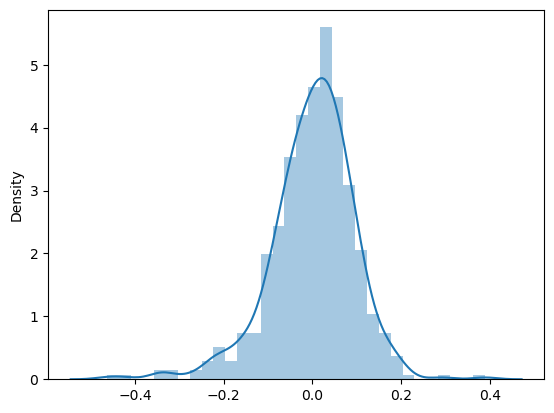

In [76]:
res = y_train - y_train_pred
sns.distplot(res)
plt.show()

In [77]:
# mean value is residing near zero and we see that the shape is normally distributed

# Predictions and evaluations

In [78]:
numeric_var = ["temp", "atemp", "hum", "windspeed", "cnt"]

df_test[numeric_var] = scaler.transform(df_test[numeric_var])

df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Aug,Dec,...,Mist,Spring,Summer,Winter,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,...,1,0,0,0,1,0,0,0,0,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,0,...,0,0,1,0,0,0,0,0,0,1
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,1,0,0,1,0,0,0,1,0,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,1,0,...,0,0,0,0,0,0,0,0,0,1
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,0,0,...,0,0,1,0,0,0,0,1,0,0


In [79]:
y_test = df_test.pop('cnt')
X_test = df_test

In [80]:
# add constant

X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,yr,holiday,workingday,temp,atemp,hum,windspeed,Aug,Dec,...,Mist,Spring,Summer,Winter,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
184,1.0,0,1,0,0.831783,0.769660,0.657364,0.084219,0,0,...,1,0,0,0,1,0,0,0,0,0
535,1.0,1,0,1,0.901354,0.842587,0.610133,0.153728,0,0,...,0,0,1,0,0,0,0,0,0,1
299,1.0,0,0,1,0.511964,0.496145,0.837699,0.334206,0,0,...,1,0,0,1,0,0,0,1,0,0
221,1.0,0,0,1,0.881625,0.795343,0.437098,0.339570,1,0,...,0,0,0,0,0,0,0,0,0,1
152,1.0,0,0,1,0.817246,0.741471,0.314298,0.537414,0,0,...,0,0,1,0,0,0,0,1,0,0


In [81]:
X_test_sm = X_test_sm[["const", "yr", "temp", "Dec", "Jan", "Jul", "Nov", "Sep", "Cloudy","Mist", "Spring", "Winter"]]
X_test_sm.head()

,const,yr,temp,Dec,Jan,Jul,Nov,Sep,Cloudy,Mist,Spring,Winter
184,1.0,0,0.831783,0,0,1,0,0,0,1,0,0
535,1.0,1,0.901354,0,0,0,0,0,0,0,0,0
299,1.0,0,0.511964,0,0,0,0,0,0,1,0,1
221,1.0,0,0.881625,0,0,0,0,0,0,0,0,0
152,1.0,0,0.817246,0,0,0,0,0,0,0,0,0


In [82]:
X_train_sm.head()

,const,yr,temp,Dec,Jan,Jul,Nov,Sep,Cloudy,Mist,Spring,Winter
576,1.0,1,0.815169,0,0,1,0,0,0,0,0,0
426,1.0,1,0.442393,0,0,0,0,0,0,1,1,0
728,1.0,1,0.245101,1,0,0,0,0,0,0,1,0
482,1.0,1,0.395666,0,0,0,0,0,0,1,0,0
111,1.0,0,0.345824,0,0,0,0,0,0,1,0,0


In [83]:
y_test_pred = lr_model.predict(X_test_sm)

In [84]:
r2_score(y_true=y_test, y_pred=y_test_pred)

0.8215709491202262

In [85]:
x_test.shape

NameError: name 'x_test' is not defined